# Part 3: Binary Image Classification w/ Convolutional Neural Networks


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-Libraries" data-toc-modified-id="Importing-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing Libraries</a></span></li><li><span><a href="#Image-Dataset" data-toc-modified-id="Image-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Image Dataset</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Confusion-Matrix-For-Binary-Classification" data-toc-modified-id="Confusion-Matrix-For-Binary-Classification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Confusion Matrix For Binary Classification</a></span></li></ul></div>

## Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os, shutil
from keras import models, layers, optimizers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import h5py
import cv2
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split,cross_val_score,KFold,StratifiedKFold
from sklearn.metrics import precision_score,recall_score,precision_recall_curve,f1_score,fbeta_score,confusion_matrix,accuracy_score,classification_report
import tensorflow.keras.models as Models
import tensorflow.keras.layers as Layers
import tensorflow.keras.utils as Utils
from sklearn.utils import shuffle
from random import randint
from scipy.interpolate import interp1d
from ipywidgets import interactive, FloatSlider
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing import image
from sklearn import decomposition
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import warnings
warnings.filterwarnings('ignore')

## Image Dataset

__Creating class names and labels:__

In [67]:
# Getting the class names of two classes from the list of 6 classes

class_names = ['buildings', 'sea']

class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

# Specifying the size of each image (it's a way to stardize since images may come in different sizes)
image_size = (150, 150)

__Generating function to load train and test image datasets and create lists with the image names and their corresponding labels:__

In [68]:
def load_images(test_train_datasets):
    
    # Train and test image datasets
    # Create an empty list to append image names and their labels
    images_and_labels_list = []
    
    # Interate through image datasets
    for dataset in test_train_datasets:
        
        images = []
        labels = []
                
        for folder in os.listdir(dataset):
            current_label = class_names_label[folder]
            # Interate through each image file in the train and test datasets
            for file in os.listdir(os.path.join(dataset, folder)):
                
                # Get the path name of the image
                image_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the image
                current_image = cv2.imread(image_path)
                current_image = cv2.resize(current_image, image_size) 
                
                # Append the image and its corresponding label to the images_and_labels_list
                images.append(current_image)
                labels.append(current_label)
        # Convert images and labels to numpy array        
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
                
        # Append images and labels to images_and_labels_list        
        images_and_labels_list.append((images, labels))
    # Return the images and labels list
    return images_and_labels_list

__Creating train/test images and labels ussing "load_images" function:__
    

In [69]:
test_train_datasets = ['../seg_train', '../seg_test']

(train_images, train_labels), (test_images, test_labels) = load_images(test_train_datasets)

__Shuffling train images and train labels:__

In [11]:
# Shuffling helps to make sure that the model is not learning the images in a sequence
train_images, train_labels = shuffle(train_images, train_labels)

__Scaling train and test images:__

In [12]:
"""
Images are scaled by 255 for an 8-bit image such that the pixel values are between 0-1. 
It is an important step which makes sure that the input parameters/pixels have a similar data distribution. 
"""
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [13]:
train_labels = to_categorical(train_labels,2)
test_labels = to_categorical(test_labels,2)

## Modeling

__Setting up convolutional neural network (CNN) layers:__

In [18]:
model_binary = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (4, 4), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (4, 4), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (4, 4), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(2, activation='sigmoid')
])

__Model Attributes:__

In [19]:
# Adding model attributes such as the choice of optimizer, loss type, and metrics of interest, i.e., accuracy in this case.
model_binary.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

__Creating Validation Dataset & Defining Fit Attributes:__

In [20]:
"""
Training model by splitting train images/labels with 30% for validation. 
"""
trained_binary_model = model_binary.fit(train_images, train_labels, batch_size=16, epochs=30, validation_split = 0.3)


Train on 3125 samples, validate on 1340 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
3125/3125 [==============================] - 67s 21ms/sample - loss: 0.4741 - acc: 0.7576 - val_loss: 0.2428 - val_acc: 0.9037
Epoch 2/30
3125/3125 [==============================] - 66s 21ms/sample - loss: 0.2188 - acc: 0.9184 - val_loss: 0.2761 - val_acc: 0.8933
Epoch 3/30
3125/3125 [==============================] - 67s 21ms/sample - loss: 0.1819 - acc: 0.9326 - val_loss: 0.1624 - val_acc: 0.9463
Epoch 4/30
3125/3125 [==============================] - 66s 21ms/sample - loss: 0.1497 - acc: 0.9446 - val_loss: 0.1539 - val_acc: 0.9388
Epoch 5/30
3125/3125 [==============================] - 66s 21ms/sample - loss: 0.1383 - acc: 0.9522 - val_loss: 0.1426 - val_acc: 0.9493
Epoch 6/30
3125/3125 [==============================] - 66s 21ms/sample - loss: 0.1230 - acc: 0.9528 - val_loss: 0.1403 - val_acc: 0.9451
Epoch 7/30
3125/3125 [==============================] - 63s 20ms/sample - lo

__Testing CNN Model On Test Images :__

In [24]:
test_loss = model_binary.evaluate(test_images, test_labels)

947/947 [==============================] - 6s 6ms/sample - loss: 0.3042 - acc: 0.9578


__Displaying An Arbitrary Image W/ Predicted Label:__

In [25]:
"""
The following function takes in class_names and their labels, 
and displays a random image with its predicted label.
"""

def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

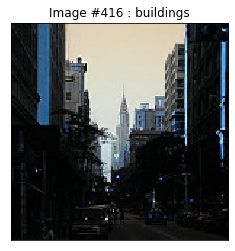

In [27]:
# Predicting label of a randomly selected test image
predictions = model_binary.predict(test_images)    
pred_labels = np.argmax(predictions, axis = 1)

# Display randomly selected 
display_random_image(class_names, test_images, pred_labels)

__Creating augmented train/test images and labels ussing "load_images" function:__

In [74]:
# Choose two classes: "buildings" and "forest"
class_names = ['buildings', 'forest']

class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

image_size = (150, 150)

In [75]:
test_train_datasets = ['../binary_augmented', '../seg_test']

(train_images_augmented, train_labels_augmented), (test_images_augmented, test_labels_augmented) = load_images(test_train_datasets)


__Shuffling augmented train images and train labels:__

In [76]:
train_images_augmented, train_labels_augmented = shuffle(train_images_augmented, train_labels_augmented)

__Scaling augmented train images:__

In [77]:
train_images_augmented = train_images_augmented / 255.0 
test_images_augmented = test_images_augmented / 255.0

In [47]:
train_labels_augmented = to_categorical(train_labels_augmented,2)
test_labels_augmented = to_categorical(test_labels_augmented,2)

In [48]:
model_binary_augmented = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (4, 4), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (4, 4), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (4, 4), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(2, activation='sigmoid')
])

__Model Attributes:__

In [49]:
model_binary_augmented.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

__Creating Validation Dataset & Defining Fit Attributes:__

In [50]:
"""
Training model by splitting train images/labels with 30% for validation. 
"""
trained_model_augmented = model_binary_augmented.fit(train_images_augmented, train_labels_augmented, batch_size=16, epochs=30, validation_split = 0.3)


Train on 13999 samples, validate on 6000 samples
Epoch 1/30
13999/13999 [==============================] - 309s 22ms/sample - loss: 0.2693 - acc: 0.8921 - val_loss: 0.2133 - val_acc: 0.9122
Epoch 2/30
13999/13999 [==============================] - 297s 21ms/sample - loss: 0.1652 - acc: 0.9371 - val_loss: 0.1535 - val_acc: 0.9417
Epoch 3/30
13999/13999 [==============================] - 317s 23ms/sample - loss: 0.1315 - acc: 0.9505 - val_loss: 0.1200 - val_acc: 0.9545
Epoch 4/30
13999/13999 [==============================] - 321s 23ms/sample - loss: 0.1068 - acc: 0.9608 - val_loss: 0.0841 - val_acc: 0.9731
Epoch 5/30
13999/13999 [==============================] - 329s 24ms/sample - loss: 0.0869 - acc: 0.9689 - val_loss: 0.0756 - val_acc: 0.9737
Epoch 6/30
13999/13999 [==============================] - 331s 24ms/sample - loss: 0.0846 - acc: 0.9690 - val_loss: 0.0832 - val_acc: 0.9708
Epoch 7/30
13999/13999 [==============================] - 318s 23ms/sample - loss: 0.0693 - acc: 0.9745 -

__Testing CNN Model On Test Images :__

In [54]:
test_loss = model_binary_augmented.evaluate(test_images_augmented, test_labels_augmented)

911/911 [==============================] - 6s 7ms/sample - loss: 0.1114 - acc: 0.9808


__Predicting Label Of Randomly Chosen Image:__

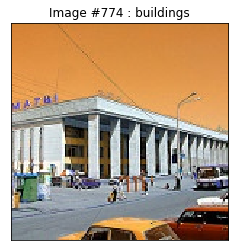

In [56]:
# Predicting label of a randomly selected test image
predictions = model_binary_augmented.predict(test_images_augmented)    
pred_labels = np.argmax(predictions, axis = 1)

# Display randomly selected image w/ prediction
display_random_image(class_names, test_images_augmented, pred_labels)

## Confusion Matrix For Binary Classification

In [78]:
def make_confusion_matrix(model, threshold=0.5):
    y_predict = (model.predict_proba(test_images_augmented)[:, 1] >= threshold)
    binary_confusion = confusion_matrix(test_labels_augmented, y_predict)
    plt.figure(dpi=80)
    sn.heatmap(binary_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d', xticklabels=['buildings', 'forest'], yticklabels=['buildings', 'forest']);
    plt.xlabel('Prediction',fontsize=15)
    plt.ylabel('Actual',fontsize=15)
    plt.savefig('BinaryConfusionMatrix_CNNaugmented.png',dpi=600)
    plt.autoscale()

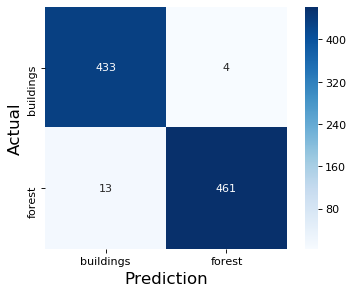

In [79]:
make_confusion_matrix(model_binary_augmented)